### classifying names of person to its origins

In [1]:
import unicodedata
import string
import glob
import os
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [2]:
def findfiles(path):
    return glob.glob(path)

In [3]:
print(findfiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [4]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
def readLines(filename):
    lines = open(filename, 'r', encoding='utf-8').readlines()[:-1]
    return [unicodeToAscii(line) for line in lines]

In [8]:
all_categories = []
category_lines = {}
for filename in findfiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [9]:
n_categories = len(all_categories)

## Turning names to tensors

In [13]:
import torch

In [29]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    # len(line) * 1 * n_letters
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor


In [31]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [23]:
import torch.nn as nn

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [36]:
x = lineToTensor('Alberta')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)

In [39]:
output

tensor([[-2.8877, -2.9497, -2.9202, -2.8271, -2.9055, -2.9761, -2.8155, -2.8047,
         -2.8697, -2.8223, -2.8882, -2.9163, -2.9470, -2.8941, -2.9033, -2.9458,
         -2.8155, -2.9642]], grad_fn=<LogSoftmaxBackward>)

In [71]:
# returns the most probable category along with its index
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    # print(top_n)
    # print(top_i)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [51]:
categoryFromOutput(output)

tensor([[-2.8047]], grad_fn=<TopkBackward>)
tensor([[7]])


('Greek', 7)

In [52]:
import random

In [56]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],
                                   dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(category, "\t", line)

Korean 	 Shim
Korean 	 Choe
Dutch 	 Schwarzenberg
Scottish 	 Jones
German 	 Abeln
Czech 	 Nekuza
German 	 Muhlfeld
Portuguese 	 De santigo
Vietnamese 	 Kim
French 	 Travert


In [57]:
criterion = nn.NLLLoss()

In [62]:
learning_rate = 0.005
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item()

In [70]:
import time
import math
from tqdm import tqdm

n_iters = 100000
log_interval = 5000
plot_interval = 1000

current_loss = 0
all_loss = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return "%dm %ds" % (m, s)

start = time.time()

for itr in tqdm(range(1, n_iters + 1), position=0, leave=True):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if itr % log_interval == 0:
        op, op_i = categoryFromOutput(output)
        correct = '✓' if op == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (itr, itr / n_iters * 100, timeSince(start), loss, line, op, correct))
    
    if itr % plot_interval == 0:
        all_loss.append(current_loss / plot_interval)
        current_loss = 0

  5%|███▊                                                                       | 5045/100000 [00:10<03:04, 514.95it/s]

tensor([[-1.4345]], grad_fn=<TopkBackward>)
tensor([[3]])
5000 5% (0m 9s) 1.4345 Ter Avest / Dutch ✓


 10%|███████▍                                                                  | 10089/100000 [00:20<03:01, 495.84it/s]

tensor([[-1.0918]], grad_fn=<TopkBackward>)
tensor([[1]])
10000 10% (0m 20s) 1.5695 Bang / Chinese ✗ (Korean)


 15%|███████████▏                                                              | 15079/100000 [00:31<02:58, 476.17it/s]

tensor([[-1.3267]], grad_fn=<TopkBackward>)
tensor([[16]])
15000 15% (0m 30s) 1.3267 Garza / Spanish ✓


 20%|██████████████▊                                                           | 20036/100000 [00:42<03:01, 440.67it/s]

tensor([[-0.7054]], grad_fn=<TopkBackward>)
tensor([[15]])
20000 20% (0m 41s) 2.4829 Ramecker / Scottish ✗ (Dutch)


 25%|██████████████████▌                                                       | 25075/100000 [00:52<02:20, 531.53it/s]

tensor([[-1.6352]], grad_fn=<TopkBackward>)
tensor([[12]])
25000 25% (0m 52s) 2.3914 Langbroek / Polish ✗ (Dutch)


 30%|██████████████████████▎                                                   | 30075/100000 [01:03<02:31, 461.98it/s]

tensor([[-1.0686]], grad_fn=<TopkBackward>)
tensor([[6]])
30000 30% (1m 3s) 2.1734 Walker / German ✗ (Scottish)


 35%|█████████████████████████▉                                                | 35056/100000 [01:13<02:15, 479.68it/s]

tensor([[-0.6473]], grad_fn=<TopkBackward>)
tensor([[6]])
35000 35% (1m 13s) 1.8848 Klemper / German ✗ (Czech)


 40%|█████████████████████████████▋                                            | 40093/100000 [01:23<02:03, 484.28it/s]

tensor([[-1.2082]], grad_fn=<TopkBackward>)
tensor([[1]])
40000 40% (1m 23s) 3.4700 Fay / Chinese ✗ (French)


 45%|█████████████████████████████████▎                                        | 45093/100000 [01:33<01:46, 517.17it/s]

tensor([[-1.2655]], grad_fn=<TopkBackward>)
tensor([[8]])
45000 45% (1m 33s) 1.2655 Brady / Irish ✓


 50%|█████████████████████████████████████                                     | 50051/100000 [01:43<01:42, 487.82it/s]

tensor([[-0.2623]], grad_fn=<TopkBackward>)
tensor([[0]])
50000 50% (1m 43s) 0.2623 Hadad / Arabic ✓


 55%|████████████████████████████████████████▊                                 | 55087/100000 [01:56<01:31, 490.26it/s]

tensor([[-0.0138]], grad_fn=<TopkBackward>)
tensor([[15]])
55000 55% (1m 56s) 0.0138 Mcmillan / Scottish ✓


 60%|████████████████████████████████████████████▍                             | 60055/100000 [02:05<01:09, 574.04it/s]

tensor([[-0.3991]], grad_fn=<TopkBackward>)
tensor([[11]])
60000 60% (2m 5s) 1.4731 Siu / Korean ✗ (Chinese)


 65%|████████████████████████████████████████████████▏                         | 65114/100000 [02:14<00:56, 617.00it/s]

tensor([[-1.5474]], grad_fn=<TopkBackward>)
tensor([[13]])
65000 65% (2m 14s) 2.1988 Grec / Portuguese ✗ (Spanish)


 70%|███████████████████████████████████████████████████▊                      | 70068/100000 [02:24<01:27, 342.29it/s]

tensor([[-1.3540]], grad_fn=<TopkBackward>)
tensor([[3]])
70000 70% (2m 24s) 2.5949 Soukup / Dutch ✗ (Czech)


 75%|███████████████████████████████████████████████████████▌                  | 75082/100000 [02:37<00:49, 502.51it/s]

tensor([[-0.4757]], grad_fn=<TopkBackward>)
tensor([[2]])
75000 75% (2m 37s) 1.7667 Awerkowitch / Czech ✗ (Russian)


 80%|███████████████████████████████████████████████████████████▎              | 80070/100000 [02:46<00:37, 533.29it/s]

tensor([[-0.7136]], grad_fn=<TopkBackward>)
tensor([[11]])
80000 80% (2m 46s) 0.7136 Shin / Korean ✓


 85%|██████████████████████████████████████████████████████████████▉           | 85087/100000 [02:55<00:26, 566.58it/s]

tensor([[-0.8527]], grad_fn=<TopkBackward>)
tensor([[11]])
85000 85% (2m 55s) 0.8527 Kim / Korean ✓


 90%|██████████████████████████████████████████████████████████████████▋       | 90099/100000 [03:04<00:16, 606.85it/s]

tensor([[-0.0974]], grad_fn=<TopkBackward>)
tensor([[13]])
90000 90% (3m 4s) 0.0974 Ramires / Portuguese ✓


 95%|██████████████████████████████████████████████████████████████████████▎   | 95069/100000 [03:13<00:08, 586.01it/s]

tensor([[-1.7274]], grad_fn=<TopkBackward>)
tensor([[6]])
95000 95% (3m 13s) 2.0200 Martel / German ✗ (French)


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [03:22<00:00, 494.92it/s]

tensor([[-0.3242]], grad_fn=<TopkBackward>)
tensor([[13]])
100000 100% (3m 22s) 0.3242 Esteves / Portuguese ✓


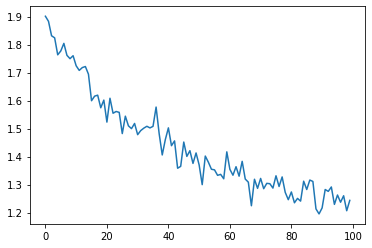

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_loss)